# Conditional Workflows using LangGraph and Qubrid AI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QubridAI-Inc/qubrid-cookbook/blob/main/Notebooks/Langgraph_Conditional_Workflows.ipynb)

![Qubrid x Langgraph](../Assets/Images/Langgraph_x_Qubrid.png)


This notebook demonstrates how to build **conditional workflows** using LangGraph, a framework for creating composable and stateful agent workflows.

Unlike traditional systems that follow fixed paths, conditional workflows enable:
- Dynamic routing based on AI analysis
- Specialized handlers for different scenarios
- State management across multiple steps
- Production-grade agent architecture

We'll build a complete agent that routes requests intelligently by analyzing sentiment and content.

**Pattern:**
```
Input → Analyze → [Decision] → Specialized Handler → Output
```


### The Pattern You'll Master


![Workflow Diagram](../Assets/Images/conditional_workflows.png)

Let's begin! 🚀

## Environment Setup

We'll use LangGraph for workflow orchestration, and Qubrid for LLM inference.



In [ ]:
%%capture
%pip install langgraph langchain-core requests

### Configuring `openai/gpt-oss-**120b**` API Key from **Qubrid AI**

In [ ]:
import os
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
import requests

from google.colab import userdata
QUBRID_API_KEY = userdata.get('QUBRID_API_KEY')

QUBRID_BASE_URL = "https://platform.qubrid.com/api/v1/qubridai"

# Using GPT OSS 120B
DEFAULT_MODEL = "openai/gpt-oss-120b"

print("✓ Configuration loaded")
print(f"✓ Using model: {DEFAULT_MODEL}")

✓ Configuration loaded
✓ Using model: openai/gpt-oss-20b


### Testing the API with Debug Info!

In [ ]:
# Test API call with debug info
print("Testing Qubrid API connection...")

test_messages = [{"role": "user", "content": "Say hello in one word."}]

response = requests.post(
    f"{QUBRID_BASE_URL}/chat/completions",
    headers={
        "Authorization": f"Bearer {QUBRID_API_KEY}",
        "Content-Type": "application/json"
    },
    json={
        "model": DEFAULT_MODEL,
        "messages": test_messages,
        "temperature": 0.5,
        "max_tokens": 50,
        "stream": False
    }
)

print(f"Status Code: {response.status_code}")
print(f"Headers: {dict(response.headers)}")
print(f"Raw Response (first 500 chars):\n{response.text[:500]}")

if response.status_code == 200:
    try:
        data = response.json()
        print(f"\n✓ JSON parsed successfully")
        print(f"Response: {data}")
    except Exception as e:
        print(f"\n✗ JSON parsing failed: {e}")

Testing Qubrid API connection...
Status Code: 200
Headers: {'Date': 'Thu, 29 Jan 2026 13:16:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '296', 'Connection': 'keep-alive', 'Set-Cookie': 'AWSALB=mVwO+qL7jREYioaFDtvoPgYc7IVE3m48fm4tuTaowCvi8Em7zJ4jpVQ15MRNYWg/OrnCQPgXEJdlaW987LCJruR4J3xRL+zOdKqcy+jybqS7cCpAs1Vhz0sC9iyd; Expires=Thu, 05 Feb 2026 13:16:41 GMT; Path=/, AWSALBCORS=mVwO+qL7jREYioaFDtvoPgYc7IVE3m48fm4tuTaowCvi8Em7zJ4jpVQ15MRNYWg/OrnCQPgXEJdlaW987LCJruR4J3xRL+zOdKqcy+jybqS7cCpAs1Vhz0sC9iyd; Expires=Thu, 05 Feb 2026 13:16:41 GMT; Path=/; SameSite=None; Secure', 'Server': 'Werkzeug/3.1.5 Python/3.10.12', 'Access-Control-Allow-Origin': '*'}
Raw Response (first 500 chars):
{
  "content": null,
  "metrics": {
    "input_tokens": 75,
    "output_tokens": 0,
    "total_time": 0.3377,
    "tps": null
  },
  "model": "openai/gpt-oss-20b",
  "usage": {
    "completion_tokens": 50,
    "prompt_tokens": 75,
    "prompt_tokens_details": null,
    "total_tokens": 125
  }
}


### Creating a Reusable Function to Call the Model

Helper function connecting to Qubrid's **GPT OSS 20B**
**Key Parameters:**
- `temperature`: `0.0 - 0.3` for classification, `0.5 - 0.8` for generation
- `max_tokens`: Response length limit

**Response includes:**
- `content`: Generated text
- `metrics`: Token counts, latency, throughput

In [ ]:
def call_qubrid(messages: list, temperature: float = 0.7, max_tokens: int = 500) -> str:
    """Call Qubrid API and return response."""
    try:
        response = requests.post(
            f"{QUBRID_BASE_URL}/chat/completions",
            headers={
                "Authorization": f"Bearer {QUBRID_API_KEY}",
                "Content-Type": "application/json"
            },
            json={
                "model": DEFAULT_MODEL,
                "messages": messages,
                "temperature": temperature,
                "max_tokens": max_tokens,
                "stream": False,  # Set to False for simpler handling
                "top_p": 1
            },
            timeout=30
        )

        response.raise_for_status()
        response_data = response.json()

        # Qubrid's response format: direct 'content' key
        if "content" in response_data:
            return response_data["content"]
        # Fallback: OpenAI-style format
        elif "choices" in response_data and len(response_data["choices"]) > 0:
            return response_data["choices"][0]["message"]["content"]
        else:
            raise ValueError(f"Unexpected response format: {response_data}")

    except requests.exceptions.JSONDecodeError as e:
        print(f"JSON Decode Error: {e}")
        print(f"Raw response: {response.text[:500]}")
        raise
    except requests.exceptions.RequestException as e:
        print(f"Request Error: {e}")
        raise
    except Exception as e:
        print(f"Unexpected Error: {e}")
        raise

## 1. Sentiment-Based Routing

We'll build a system that analyzes sentiment and routes to specialized handlers.


**Flow:**
```
Message → Analyze Sentiment → Route by Result → Generate Response
                    ↓
            positive/negative/neutral
```


In [ ]:
# Define State
class MessageState(TypedDict):
    message: str
    sentiment: str  # positive, negative, neutral
    response: str

# Node 1: Analyze sentiment
def analyze_sentiment(state: MessageState) -> MessageState:
    print("→ Analyzing sentiment...")

    prompt = f"""Analyze the sentiment of this message. Reply with ONLY one word: positive, negative, or neutral.

Message: {state['message']}

Sentiment:"""

    sentiment = call_qubrid(
        [{"role": "user", "content": prompt}],
        temperature=0.3
    ).strip().lower()

    print(f"  Detected: {sentiment}")
    return {**state, "sentiment": sentiment}

# Node 2a: Handle positive
def handle_positive(state: MessageState) -> MessageState:
    print("→ Generating positive response...")

    response = call_qubrid([{
        "role": "user",
        "content": f"Generate an enthusiastic, friendly response to: {state['message']}"
    }])

    return {**state, "response": response}

# Node 2b: Handle negative
def handle_negative(state: MessageState) -> MessageState:
    print("→ Generating empathetic response...")

    response = call_qubrid([{
        "role": "user",
        "content": f"Generate an empathetic, solution-focused response to: {state['message']}"
    }])

    return {**state, "response": response}

# Node 2c: Handle neutral
def handle_neutral(state: MessageState) -> MessageState:
    print("→ Generating informative response...")

    response = call_qubrid([{
        "role": "user",
        "content": f"Generate a clear, informative response to: {state['message']}"
    }])

    return {**state, "response": response}

# Routing function - THE KEY!
def route_by_sentiment(state: MessageState) -> Literal["positive", "negative", "neutral"]:
    """Route to handler based on sentiment."""
    print(f"→ Routing to {state['sentiment']} handler")
    return state['sentiment']

## Building the Workflow Graph

Define the workflow structure with nodes (processing functions) and conditional edges (dynamic routing).

In [ ]:
# Build workflow
workflow = StateGraph(MessageState)

# Add nodes
workflow.add_node("analyze", analyze_sentiment)
workflow.add_node("positive", handle_positive)
workflow.add_node("negative", handle_negative)
workflow.add_node("neutral", handle_neutral)

# Entry point
workflow.set_entry_point("analyze")

# Conditional routing - THIS IS THE PATTERN!
workflow.add_conditional_edges(
    "analyze",              # From this node
    route_by_sentiment,     # Use this function to decide
    {
        "positive": "positive",
        "negative": "negative",
        "neutral": "neutral"
    }
)

# All paths end
workflow.add_edge("positive", END)
workflow.add_edge("negative", END)
workflow.add_edge("neutral", END)

# Compile
app = workflow.compile()
print("✓ Workflow ready")

✓ Workflow ready


**How it works:**
- Directed graph where state flows through nodes
- `add_conditional_edges` enables dynamic branching
- `.compile()` creates executable workflow

**Flow:** `Input → analyze → [route] → handler → END`


## Workflow Visualization

The graph shows how messages flow through analysis, routing, and response generation.

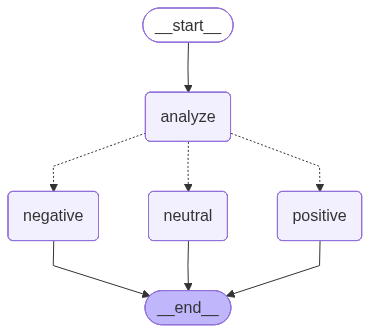

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    print("Graph: analyze → [positive/negative/neutral] → END")

## Testing the Agent


Test all three routing paths with different sentiment inputs.


In [ ]:
# Test 1: Positive message
print("=" * 60)
print("TEST 1: Positive Message")
print("=" * 60)

result = app.invoke({
    "message": "I absolutely love your product! It's been a game-changer for my workflow.",
    "sentiment": "",
    "response": ""
})

print(f"\nResponse:\n{result['response']}\n")

TEST 1: Positive Message
→ Analyzing sentiment...
  Detected: positive
→ Routing to positive handler
→ Generating positive response...

Response:
Hey there! 🎉

We’re absolutely thrilled to hear that our product is making such a positive impact on your workflow! Knowing it’s a game‑changer for you means everything to us. If there’s anything else we can do to keep the momentum going—or if you have any cool tips or features you’d love to see next—just give us a shout. Thanks for being such an awesome customer! 🚀✨



In [ ]:
# Test 2: Negative message
print("=" * 60)
print("TEST 2: Negative Message")
print("=" * 60)

result = app.invoke({
    "message": "This is frustrating. The feature I need keeps breaking.",
    "sentiment": "",
    "response": ""
})

print(f"\nResponse:\n{result['response']}\n")

TEST 2: Negative Message
→ Analyzing sentiment...
  Detected: negative
→ Routing to negative handler
→ Generating empathetic response...

Response:
I’m really sorry you’re hitting this snag—those moments can be incredibly frustrating. Let’s see if we can get the feature back on track together.

**First, a quick sanity check:**

1. **Refresh the page** (or restart the app) – sometimes a fresh load clears a hiccup.  
2. **Clear your browser cache** (or the app’s local data) – stale files can cause odd behavior.  
3. **Try a different device/browser** – this helps us determine if it’s a local issue or a broader glitch.

If those steps don’t resolve it, could you share a bit more detail?

- What exactly were you doing when it broke (e.g., opening a specific page, clicking a button, uploading a file)?  
- Do you see any error messages or unusual activity in the console (e.g., “Network error 500” or “Failed to load resource”)?
- Has this issue happened before, or is it a brand-new problem?



In [ ]:
# Test 3: Neutral message
print("=" * 60)
print("TEST 3: Neutral Message")
print("=" * 60)

result = app.invoke({
    "message": "What's the difference between your Pro and Enterprise plans?",
    "sentiment": "",
    "response": ""
})

print(f"\nResponse:\n{result['response']}\n")

TEST 3: Neutral Message
→ Analyzing sentiment...
  Detected: neutral
→ Routing to neutral handler
→ Generating informative response...

Response:
**Pro vs. Enterprise – what you’ll actually get**

| Feature | Pro Plan | Enterprise Plan |
|---------|----------|-----------------|
| **Target audience** | Individuals, freelancers, or small teams (≤ 10–20 users) | Medium to large organizations (≥ 10–20 users, often with multiple departments) |
| **Core functionality** | All core product features (e.g., project management, analytics, basic integrations) | Same core features plus advanced modules (e.g., data warehousing, AI‑driven insights, custom dashboards) |
| **User seats** | Fixed number of seats (usually capped at 10–20) | Unlimited or highly scalable seat count; can be negotiated in bulk |
| **Storage & compute limits** | Moderate storage (e.g., 10 GB–50 GB) and compute quotas | Enterprise‑grade storage (tens of TB) and compute resources, often with dedicated instances |
| **Custom int

## 2. Example Usage: Support Ticket Router

Now let's level up to a more realistic scenario that mirrors actual production systems.

In [ ]:
class TicketState(TypedDict):
    ticket: str
    category: str  # billing, technical, account, general
    priority: str
    response: str

def classify_ticket(state: TicketState) -> TicketState:
    prompt = f"""Classify this support ticket. Reply ONLY with: category|priority
Categories: billing, technical, account, general
Priority: low, medium, high

Ticket: {state['ticket']}

Classification:"""

    result = call_qubrid([{"role": "user", "content": prompt}], temperature=0.2)
    category, priority = result.strip().split("|")

    return {**state, "category": category.strip(), "priority": priority.strip()}

def handle_billing(state: TicketState) -> TicketState:
    response = call_qubrid([{"role": "user", "content":
        f"Generate a billing support response for: {state['ticket']}"}])
    return {**state, "response": response}

def handle_technical(state: TicketState) -> TicketState:
    response = call_qubrid([{"role": "user", "content":
        f"Generate a technical support response for: {state['ticket']}"}])
    return {**state, "response": response}

def handle_account(state: TicketState) -> TicketState:
    response = call_qubrid([{"role": "user", "content":
        f"Generate an account support response for: {state['ticket']}"}])
    return {**state, "response": response}

def handle_general(state: TicketState) -> TicketState:
    response = call_qubrid([{"role": "user", "content":
        f"Generate a general support response for: {state['ticket']}"}])
    return {**state, "response": response}

def route_ticket(state: TicketState) -> Literal["billing", "technical", "account", "general"]:
    return state["category"]

In [ ]:
# Build ticket router
ticket_workflow = StateGraph(TicketState)

ticket_workflow.add_node("classify", classify_ticket)
ticket_workflow.add_node("billing", handle_billing)
ticket_workflow.add_node("technical", handle_technical)
ticket_workflow.add_node("account", handle_account)
ticket_workflow.add_node("general", handle_general)

ticket_workflow.set_entry_point("classify")

ticket_workflow.add_conditional_edges(
    "classify",
    route_ticket,
    {"billing": "billing", "technical": "technical",
     "account": "account", "general": "general"}
)

ticket_workflow.add_edge("billing", END)
ticket_workflow.add_edge("technical", END)
ticket_workflow.add_edge("account", END)
ticket_workflow.add_edge("general", END)

ticket_app = ticket_workflow.compile()
print("✓ Ticket router ready")

✓ Ticket router ready


In [ ]:
# Test ticket routing
tickets = [
    "I was charged twice this month",
    "The app crashes when I export data",
    "Can't reset my password",
    "What are your business hours?"
]

for ticket in tickets:
    print(f"\nTicket: {ticket}")
    result = ticket_app.invoke({
        "ticket": ticket,
        "category": "",
        "priority": "",
        "response": ""
    })
    print(f"→ Routed to: {result['category']} | Priority: {result['priority']}")
    print(f"Response: {result['response'][:100]}...\n")


Ticket: I was charged twice this month
→ Routed to: billing | Priority: high
Response: **Subject:** Your Billing Inquiry – Duplicate Charge

Hi [Customer Name],

Thank you for reaching ou...


Ticket: The app crashes when I export data
→ Routed to: technical | Priority: high
Response: **Subject:** Re: App crashes when exporting data – let’s get it fixed

Hi [User Name],

Thanks for r...


Ticket: Can't reset my password
→ Routed to: account | Priority: high
Response: Hi there,

I’m sorry you’re having trouble resetting your password. Let’s get this sorted out togeth...


Ticket: What are your business hours?
→ Routed to: general | Priority: low
Response: **Support Team – Business Hours**

Our standard operating hours are:

- **Monday – Friday:** 9:00 am...



## Summary

We've built a conditional workflow system that goes beyond simple linear chains by:

- Making dynamic routing decisions based on AI analysis
- Managing state across multiple processing steps
- Enabling specialized handlers for different scenarios
- Demonstrating production-grade agent patterns

This approach enables more intelligent and adaptable AI systems than traditional fixed-path workflows, especially for complex scenarios requiring context-aware routing.




## Start Building Intelligent Agents ⚡

[🔑 Get Your API Key](https://platform.qubrid.com/signup) ·
[🤖 Explore Available Models](https://docs.platform.qubrid.com/inferencing/Serverless%20Models) ·
[🏏 Try the Playground](https://platform.qubrid.com/playground)

__Build, deploy, and scale agentic workflows with Qubrid AI.__